In [1]:
%load_ext autoreload

In [2]:
import data.merge_data as md
import re
import pandas as pd
import matplotlib.pyplot as plt

### Load and process the data

First of all, we put all the messages into a single list while removing all non-alphanumeric characters. The result should be just a huge list of words, which we're going to work with. We also introduce a `min_len` variable to be able to only analyze words longer than some specific value.

In [3]:
data = md.get_data()
msg = data['body']
min_len = 0
words = []
for i, m in enumerate(msg.items()):
    lst = re.split('\s+', m[1].lower())
    lst = [''.join(e for e in x if e.isalnum()) for x in lst]  # remove special chars
    lst = [x for x in lst if len(x) > min_len]  # remove words shorter than N
    words.extend(lst)

Check how many words do we have in total

In [4]:
len(words)

641877

Next we use the bult-in `Counter` class to actually count the number of occurences of each word in the list and sort them from most common to least common.

In [5]:
from collections import Counter
c = Counter(words)
df = pd.DataFrame(c.most_common())
df.columns = ['word', 'freq']

Check how many unique words do we have in total. This may be considered as an estimate of the user's vocabulary, but one should take into account that our simple approach:
- treats different forms of a word as multiple unique words (e.g. 'car', 'cars');
- doesn't detect and correct typos, so each mistyped word is basically a new unique word in our list;
- doesn't clean URLs, emails and lots of other grabage character sequences that may be used in text messages but don't really make any sense for word distribution analysis.

So realistically I would probably divide this by a factor of (at least) 2 for a better estimate :)

In [6]:
len(df)

62823

### Plot the distribution for the most frequent 170 words

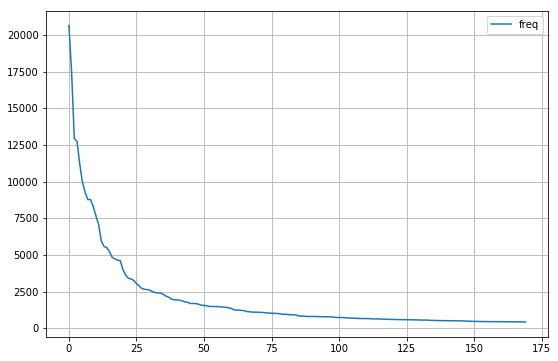

In [7]:
df[0:170].plot(figsize=(9,6), grid=True) #, logx=True, logy=True)
plt.show()

So, here it is. Apparently it is an example of a power-law distribution. According to [wiki](https://en.wikipedia.org/wiki/Zipf%27s_law) (and lot's of other sources) the words distribution in natural languages is described by Zipf's law:

$$\displaystyle f(k;s,N)={\frac {k^{-s}}{\sum \limits _{n=1}^{N}(n^{-s})}}$$

which is basically a discrete counterpart of Pareto distribution.
Luckily `scipy.stats` module has Zipf distributions implemented, so we can plot it really easily just for comparison.

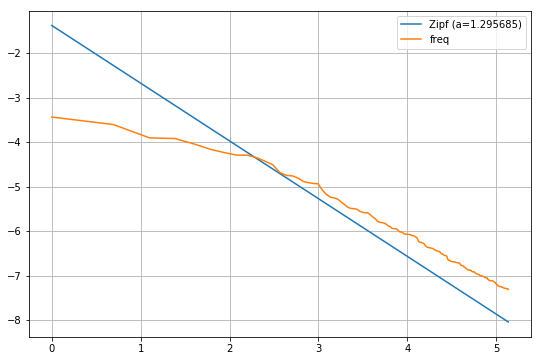

In [44]:
from scipy.stats import zipf
import numpy as np
x = np.arange(1, 171, 1)
a = 1.3
f = plt.figure(figsize=(9,6))
plt.plot(np.log(x), np.log(zipf.pmf(x, a)), label='Zipf (a=%f)' % a)
# normalize the frequencies so that they sum to 1.0
plt.plot(np.log(x), np.log(df['freq'][0:170] / df['freq'].sum()), label='freq')
plt.legend()
plt.grid()
plt.show()

In theory we can fit the parameters of Zipf's law to our dataset using, for example, the maximum likelihood estimate. But here it's pretty clear just from looking at the figure that it's not going to be a very good fit. Zipf's probability mass function (PMF) should look like a straight line on the log/log scale, but it's not the case for our empirical frequency distribution line. One reason for this may be that a dataset generated from just one person's messages in not really a representative sample.. But I believe it's much likely to be a data processing issue (see bulletpoints in the end of the "Load and process data" section"). Anyway, it is something to consider for future work and I leave the parameters fitting code below in case you want to play with it.

In [37]:
from scipy.special import zeta
# negative log likelihood function for Zipf's distribution
def zipf_loglike(s, x):
    return s * np.sum(x * np.log(np.arange(1,len(x)+1))) + np.sum(x) * np.log(zeta(s))
# sum of squared errors for log sample and Zipf's log PMF
def zipf_lse(s, x):
    return np.sum(np.square(np.log(zipf.pmf(np.arange(1, len(x)+1), s)) - np.log(x)))

In [ ]:
from scipy.optimize import minimize
from functools import partial

# normalize frequencies so that they sum to unity
sample = (df['freq'][0:170] / df['freq'].sum()).as_matrix()

# fit with both methods and compare
res0 = minimize(partial(zipf_loglike, x=sample), 1.03, bounds=[(1.000001, None)])
print(res0)
res1 = minimize(partial(zipf_lse, x=sample), 1.03, bounds=[(1.000001, None)])
print(res1)

### Show me the words!

Finally, it may be fun just to see some of the most used words from your conversations, so I leave a bunch of example templates here for anyone who wants to play around with it with their own datasets :)

In [ ]:
# top 100 most used words (most of it will be just boring short 1-3 character words)
df.iloc[0:100]

In [ ]:
# top 100 most used words longer than 5 characters (should be more interesting to look at :)
df.loc[df['word'].str.len() > 5].iloc[0:100]

In [ ]:
# words starting with a specific letter, sorted by use frequency
df.loc[df['word'].str.get(0) == 'p']

In [ ]:
# words containing specific characters pattern, arranged by use frequency
df.loc[df['word'].str.contains('pattern')]

In [ ]:
# words containing any of the patterns provided in the list, arranged by use frequency
patterns = ['omg', 'wtf', 'lol']
df.loc[df['word'].str.contains('|'.join(patterns))]

Well, I think you get the idea and can come up with more examples :)